In [1]:
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision    
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import os
from PIL import Image
import torch.nn.functional as TNF
import torchvision.transforms.functional as TF
import pandas as pd


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
directory_path = 'A_05_Part_02_Dataset'

In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(directory_path + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(directory_path + '/Test', transform=test_transforms )
valid_data = datasets.ImageFolder(directory_path + '/Validation', transform=train_transforms)


print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


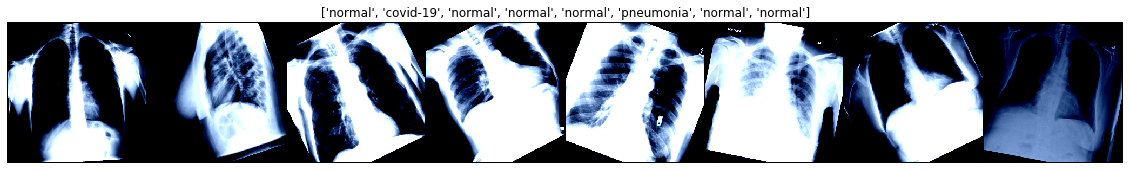

In [4]:

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(20,10))
    imshow(out, title=[class_names[x] for x in classes])


# #data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)



# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [5]:
class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2):
        super(FocalLoss,self).__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,inputs,targets):
        
        prob=TNF.binary_cross_entropy_with_logits(inputs,targets,reduce=False)
        pt=torch.exp(-prob)
        FL=self.alpha*(1-pt)**self.gamma*prob
        
        return torch.mean(FL)

In [6]:

        

def freez_layers(freezLayer, model, model_name):
    # input values
    # 'all' to freez all layers
    # 'none' to unfreez all layers
    # integer value to freez n layers

    # to freez all Layers
    if type (freezLayer) == type ('str') and freezLayer == 'all':
        if model_name == 'vgg16':
            for param in model.features.parameters():
                param.require_grad = False
        elif model_name == 'resnet18':
            for param in model.parameters():
                param.require_grad = False

        print ("Layers freezed = ALL" )

    elif type (freezLayer) == type ('str') and freezLayer == 'none':
        print ("Layers freezed = NONE")

    # pass integer freezLayer = 2 it will keep last 2 layers unfreezed
    # and will freez reset of the layers
    # if there are n layers and input is m then n-m layers will be freezed
    # and m layers will be unfreezed
    elif type (freezLayer) !=type ('str'):   
        size = 0
        index = 0

        # no_of_unfreezing_layers = 0   freez all layers
        # no_of_unfreezing_layers = n   freez layers upto n
        if model_name == 'vgg16':
            for param in model.features.parameters():
                size = size + 1
            no_of_unfreezing_layers = size - freezLayer 

            for param in model.features.parameters():
                if index < no_of_unfreezing_layers:
                    param.require_grad = False
#                         print('Freezing Layer '+str(index+1))

                index = index+1

        elif model_name == 'resnet18':
            for param in model.parameters():
                size = size + 1
            no_of_unfreezing_layers = size - freezLayer

            for param in model.parameters():
                if index < no_of_unfreezing_layers:
                    param.require_grad = False
#                         print('Freezing Layer '+str(index+1))

                index = index+1

        print ("Layers freezed = ", freezLayer)
    return model

def get_classifier_in_features(modelName, model):
    if modelName == 'resnet18':
        return model.fc.in_features
    else :
        return model.classifier[0].in_features



def replacelayers( fc, model, model_name):
    
    features = fc
    # remove all FC Layers and  replace it with our FC layers
    if model_name == 'resnet18':
        model.fc = nn.Sequential(*features)
    else:
        model.classifier = nn.Sequential(*features)
    return model




def generateConfusionMatrix( labels, y_pred, classnames,matrix_name = " ", plot_graph = False):
    
    matrix1 = multilabel_confusion_matrix(labels, y_pred, labels = [0,1,2])  
    print (matrix1)
    
    matrix = confusion_matrix(labels, y_pred)
    
    plt.figure(figsize= (5,5))
    ax = plt.subplot(111)
    
    if plot_graph == True:
        ConfusionMatrixDisplay(matrix, classnames).plot(
            include_values=True, xticks_rotation="vertical", ax = ax, values_format = "1")
        plt.title(matrix_name+  " Confusion Matriz")
        plt.tight_layout()
        plt.show()
        
    precision = precision_score(labels, y_pred, labels=[0, 1 , 2], average='micro')
    recall = recall_score(labels, y_pred, labels=[0, 1 , 2], average='micro')
    f1 = f1_score(labels, y_pred, labels=[0, 1 , 2], average='micro')
    accuracy = accuracy_score(labels, y_pred)
    
    
#     TP = np.diag(matrix)
#     FP = np.sum(matrix, axis= 0 ) - TP
#     FN = np.sum(matrix, axis = 1) - TP
#     precision = TP/(TP+FP)
#     recall = TP/(TP+FN)
    
#     f1 = getF1Measure/(precision,recall)
    return accuracy, precision, recall, f1

def getF1Measure(precision, recall):
    f1 = 2* (precision*recall) / (precision + recall )
    return f1

def train(model,thresh_hold,  trainloader, valid_loader, optimizer, Epochs, criterion, device, model_name):
    print ("**********************  TRAINING  ******************************")

    #if you have gpu then you need to convert the network and data to cuda
    #the easiest way is to first check for device and then convert network and data to device
    if torch.cuda.is_available():
        print ('running on GPU')
    else:
        print('running on CPU')


    model.to(device)

    model.train()
    train_loss_list = list()
    validation_loss_list = list()
    train_accuracy_list = list()
    Validation_accuracy_list = list()

    
    
    for epoch in range(Epochs):  # loop over the dataset multiple times

        training_predicting_label = torch.zeros(0,dtype=torch.long, device=device)
        training_true_label = torch.zeros(0,dtype=torch.long, device=device)

        validating_predicting_label = torch.zeros(0,dtype=torch.long, device=device)
        validating_true_label = torch.zeros(0,dtype=torch.long, device=device)
   
       
        
        correct = 0.0
        running_loss = 0.0
        total = 0.0
        pbar = tqdm(enumerate(trainloader), position=0, leave=True)
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            y=torch.zeros(len(labels),3)

            my_labels = labels

            x=list(my_labels.shape)
            for j in range(x[0]):
                if(labels[j]==0):
                    y[j,0]=1
                    y[j,1]=0
                    y[j,2]=1
                elif(labels[j]==1):
                    y[j,0]=0
                    y[j,1]=1
                    y[j,2]=0
                elif(labels[j]==2):
                    y[j,0]=0
                    y[j,1]=0
                    y[j,2]=1
            
            y = y.to(device)
              
            inputs, labels = inputs.to(device), y.to(device)

                
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)               #----> forward pass
            predicted = torch.sigmoid(outputs.data)>thresh_hold
            predicted = predicted.to(torch.long)
            
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update
            running_loss += loss.item() 
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

            training_predicting_label = torch.cat([training_predicting_label,predicted.view(-1)])
            training_true_label = torch.cat([training_true_label,labels.to(torch.long).view(-1)])



            
            torch.save(model.state_dict(), model_name)
            
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    loss.item()))


        train_loss_list.append(running_loss)
        train_accuracy_list.append(np.round((100 * correct / total),decimals=4))




        correct = 0.0
        running_loss = 0.0
        total = 0.0
        pbar = tqdm(enumerate(valid_loader), position=0, leave=True)
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            y=torch.zeros(len(labels),3)
        
            my_labels = labels
            
            x=list(my_labels.shape)
            for k in range(x[0]):
                if(labels[k]==0):
                    y[k,0]=1
                    y[k,1]=0
                    y[k,2]=1
                elif(labels[k]==1):
                    y[k,0]=0
                    y[k,1]=1
                    y[k,2]=0
                elif(labels[k]==2):
                    y[k,0]=0
                    y[k,1]=0
                    y[k,2]=1
            
            y = y.to(device)
            inputs, labels = inputs.to(device), y.to(device)
            

            # forward + backward + optimize
            outputs = model(inputs)               #----> forward pass
            
            predicted = torch.sigmoid(outputs.data)>thresh_hold
            predicted = predicted.to(torch.long)
        
            loss = criterion(outputs, labels)   #----> compute loss
            
            running_loss += loss.item() 

            # check accuracy of the train data
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            validating_predicting_label = torch.cat([validating_predicting_label,predicted.view(-1)])
            validating_true_label = torch.cat([validating_true_label,labels.to(torch.long).view(-1)])


        validation_loss_list.append(running_loss)
        Validation_accuracy_list.append(np.round((100 * correct / total),decimals=4))

    
        
        
        print("Epochs "+ str(epoch)+" Training Confusion Martis")
        accuracy, precison, recall, f1 = generateConfusionMatrix(training_true_label.cpu().numpy(), training_predicting_label.cpu().numpy(), class_names,"Training "+model_name, True)

        print ("Epochs "+ str(epoch)+ " Training Accuracy : ",  np.round(accuracy,decimals=4) *100, ' F1 Score : ', np.round(f1,decimals=4))


        print("Epochs "+ str(epoch)+" Validation Confusion Martis")

        accuracy, precison, recall, f1 = generateConfusionMatrix(validating_true_label.cpu().numpy(), validating_predicting_label.cpu().numpy(), class_names,'Validation '+model_name, True)

        print ("Epochs "+ str(epoch)+" Validating Accuracy : ",  np.round(accuracy,decimals=4) *100, ' F1 Score : ', np.round(f1,decimals=4))




    plt.plot(range(0,len(train_loss_list)), train_loss_list, "r", label = model_name + " - Training Loss curve") 
    plt.plot(range(0,len(validation_loss_list)), validation_loss_list, "b", label = model_name + " - Validation Loss curve") 
    plt.xlabel("epochs")
    plt.ylabel("Error")
    plt.title(model_name+" Loss Curve graph")
    plt.legend()
    plt.show()

    plt.plot(range(0,len(train_accuracy_list)), train_accuracy_list, "r", label = model_name + " - Training Accuracy curve") 
    plt.plot(range(0,len(Validation_accuracy_list)), Validation_accuracy_list, "b", label = model_name + " - Validation Accuracy curve") 
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title(model_name+" Accuracy Curve graph")
    plt.legend()
    plt.show()


    print ("********************** END TRAINING  ******************************")

    
#     model, training_predicting_label.cpu().numpy(), training_true_label.cpu().numpy(), validating_predicting_label.cpu().numpy(), validating_true_label.cpu().numpy()
    return model




def test(model, testloader, device, thresh_hold,  model_csv_name, test_label = "test"):

    print ("**********************  Testing  ******************************")

    predictions = list()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)>thresh_hold
            preds = preds.to(torch.int32)
            predictions.append(preds.cpu().numpy())
    
    
    file_name = []
    paths = test_data.imgs
    for path in paths:
        name = path[0].split('\\')[2]
        file_name.append(name.split('.')[0])
    
    index = 0
    csv = pd.DataFrame(columns = ['image name', 'Covid', 'pneumonia', 'normal'])
    for batch_result in predictions:
        for image_result in batch_result:
            csv = csv.append( pd.DataFrame({'image name': [file_name[index]] , 'Covid': [image_result[0]], 'pneumonia': [image_result[2]], 'normal':[image_result[1]]}))
            index += 1
    csv.to_csv(directory_path+"/"+model_csv_name+".csv", index = False)


    print ("********************** END Testing  ******************************")
#     return accuracy_list

In [7]:
def customOneHotEncoding(labels):
    encode_labels = np.zeros((len(labels), len(class_names)))
    index = 0
    for label in labels:
        encoded_arra = np.zeros(3, dtype = np.float)
        if label == 0:
            encoded_arra[0] = 1
            encoded_arra[2] = 1
        elif label == 1:
            encoded_arra[1] = 1
        elif label == 2:
            encoded_arra[2] = 1
            
        encode_labels [index] = encoded_arra
        
        index += 1
        
        
#     print (encode_labels)
    return encode_labels

##### Test 1 Vgg on BEC

In [8]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
features = list()
model_name = "vgg16"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelT1V = vgg16_d

############################# Freezing Layer ########################################
modelT1V = freez_layers('none', modelT1V, 'vgg16')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('vgg16', modelT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", model.getModel())
modelT1V = replacelayers(features, modelT1V, 'vgg16')
# print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.368309: : 620it [22:26,  2.17s/it]
63it [00:55,  1.14it/s]


Epochs 0 Training Confusion Martis
[[[ 5576   824]
  [  651 11549]]

 [[11549   651]
  [  824  5576]]

 [[18600     0]
  [    0     0]]]


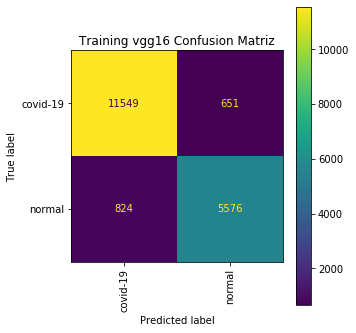

Epochs 0 Training Accuracy :  92.07  F1 Score :  0.9207
Epochs 0 Validation Confusion Martis
[[[ 594   62]
  [  45 1183]]

 [[1183   45]
  [  62  594]]

 [[1884    0]
  [   0    0]]]


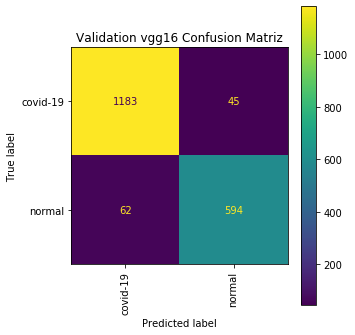

Epochs 0 Validating Accuracy :  94.32000000000001  F1 Score :  0.9432


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.316760: : 620it [23:27,  2.27s/it]
63it [00:58,  1.08it/s]


Epochs 1 Training Confusion Martis
[[[ 5830   570]
  [  466 11734]]

 [[11734   466]
  [  570  5830]]

 [[18600     0]
  [    0     0]]]


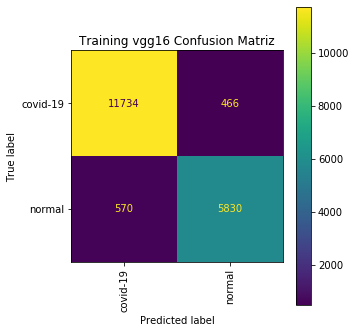

Epochs 1 Training Accuracy :  94.43  F1 Score :  0.9443
Epochs 1 Validation Confusion Martis
[[[ 597   59]
  [  43 1185]]

 [[1185   43]
  [  59  597]]

 [[1884    0]
  [   0    0]]]


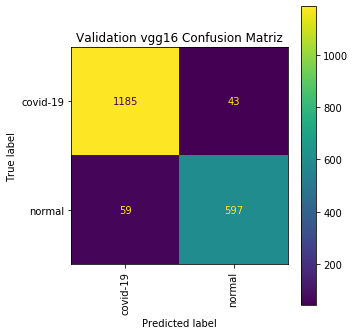

Epochs 1 Validating Accuracy :  94.59  F1 Score :  0.9459


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.039034: : 620it [24:02,  2.33s/it]
63it [00:51,  1.22it/s]


Epochs 2 Training Confusion Martis
[[[ 5890   510]
  [  432 11768]]

 [[11768   432]
  [  510  5890]]

 [[18600     0]
  [    0     0]]]


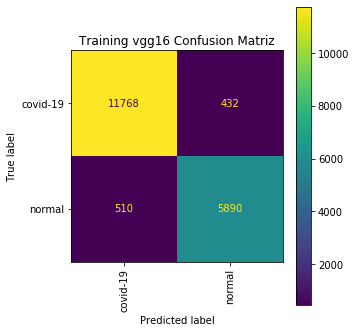

Epochs 2 Training Accuracy :  94.94  F1 Score :  0.9494
Epochs 2 Validation Confusion Martis
[[[ 598   58]
  [  43 1185]]

 [[1185   43]
  [  58  598]]

 [[1884    0]
  [   0    0]]]


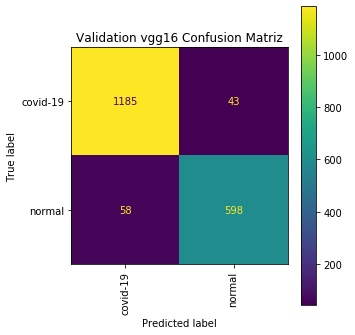

Epochs 2 Validating Accuracy :  94.64  F1 Score :  0.9464


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.059149: : 620it [21:06,  2.04s/it]
63it [00:39,  1.61it/s]


Epochs 3 Training Confusion Martis
[[[ 5988   412]
  [  354 11846]]

 [[11846   354]
  [  412  5988]]

 [[18600     0]
  [    0     0]]]


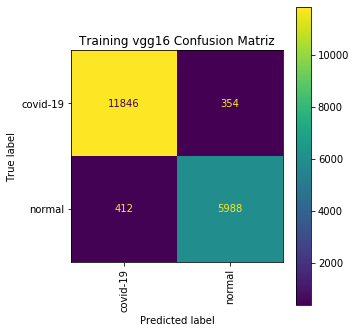

Epochs 3 Training Accuracy :  95.88  F1 Score :  0.9588
Epochs 3 Validation Confusion Martis
[[[ 605   51]
  [  39 1189]]

 [[1189   39]
  [  51  605]]

 [[1884    0]
  [   0    0]]]


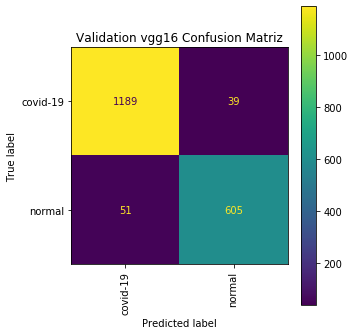

Epochs 3 Validating Accuracy :  95.22  F1 Score :  0.9522


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.120613: : 620it [21:47,  2.11s/it]
63it [00:51,  1.21it/s]


Epochs 4 Training Confusion Martis
[[[ 6024   376]
  [  333 11867]]

 [[11867   333]
  [  376  6024]]

 [[18600     0]
  [    0     0]]]


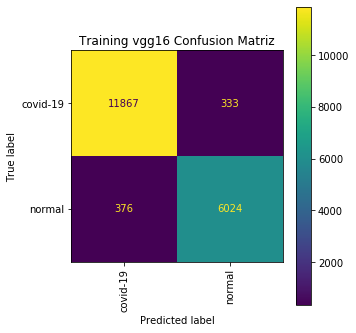

Epochs 4 Training Accuracy :  96.19  F1 Score :  0.9619
Epochs 4 Validation Confusion Martis
[[[ 614   42]
  [  32 1196]]

 [[1196   32]
  [  42  614]]

 [[1884    0]
  [   0    0]]]


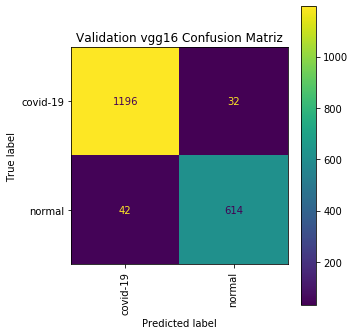

Epochs 4 Validating Accuracy :  96.07  F1 Score :  0.9607


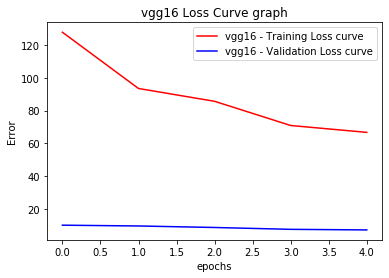

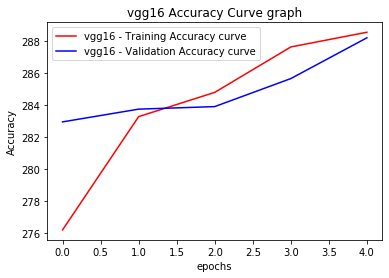

********************** END TRAINING  ******************************


In [9]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = nn.BCEWithLogitsLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelT1V = train(modelT1V, 0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)

# ############################## Saving Model  #######################################
pickle.dump(modelT1V, open('vgg16_BCET1V.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [10]:


m = pickle.load(open('vgg16_BCET1V.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "vgg16_BCET1V")


**********************  Testing  ******************************
********************** END Testing  ******************************


##### Test 2 VGG on BCE

In [10]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
features = list()
model_name = "vgg16"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelT1V = vgg16_d

############################# Freezing Layer ########################################
modelT1V = freez_layers('none', modelT1V, 'vgg16')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('vgg16', modelT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 1360 )])
# Adding last layer 
features.extend([nn.Linear(1360, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", model.getModel())
modelT1V = replacelayers(features, modelT1V, 'vgg16')
# print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=25088, out_features=1360, bias=True), Linear(in_features=1360, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.060607: : 620it [22:05,  2.14s/it]
63it [00:43,  1.45it/s]


Epochs 0 Training Confusion Martis
[[[ 5569   831]
  [  677 11523]]

 [[11523   677]
  [  831  5569]]

 [[18600     0]
  [    0     0]]]


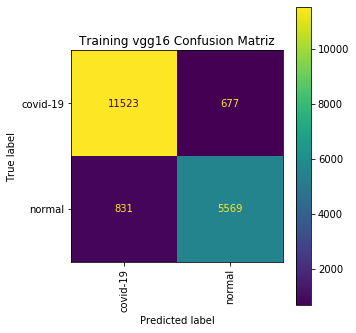

Epochs 0 Training Accuracy :  91.89  F1 Score :  0.9189
Epochs 0 Validation Confusion Martis
[[[ 575   81]
  [  56 1172]]

 [[1172   56]
  [  81  575]]

 [[1884    0]
  [   0    0]]]


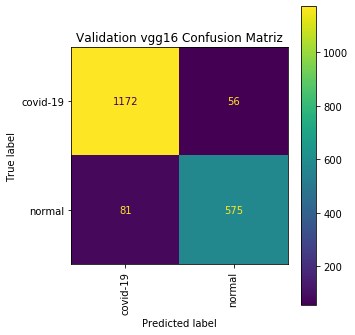

Epochs 0 Validating Accuracy :  92.73  F1 Score :  0.9273


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.197099: : 620it [23:49,  2.31s/it]
63it [00:54,  1.16it/s]


Epochs 1 Training Confusion Martis
[[[ 5838   562]
  [  444 11756]]

 [[11756   444]
  [  562  5838]]

 [[18600     0]
  [    0     0]]]


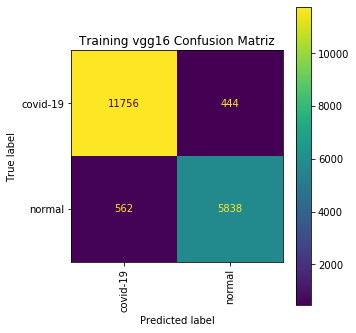

Epochs 1 Training Accuracy :  94.59  F1 Score :  0.9459
Epochs 1 Validation Confusion Martis
[[[ 603   53]
  [  37 1191]]

 [[1191   37]
  [  53  603]]

 [[1884    0]
  [   0    0]]]


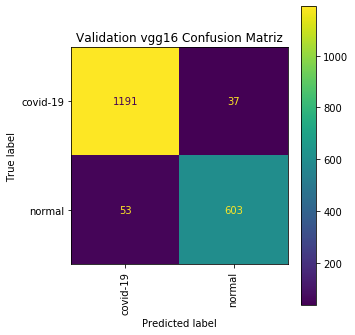

Epochs 1 Validating Accuracy :  95.22  F1 Score :  0.9522


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.019206: : 620it [24:23,  2.36s/it]
63it [01:21,  1.29s/it]


Epochs 2 Training Confusion Martis
[[[ 5932   468]
  [  399 11801]]

 [[11801   399]
  [  468  5932]]

 [[18600     0]
  [    0     0]]]


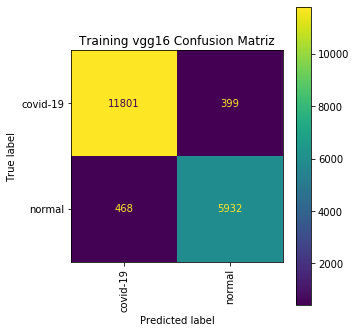

Epochs 2 Training Accuracy :  95.34  F1 Score :  0.9534
Epochs 2 Validation Confusion Martis
[[[ 602   54]
  [  43 1185]]

 [[1185   43]
  [  54  602]]

 [[1884    0]
  [   0    0]]]


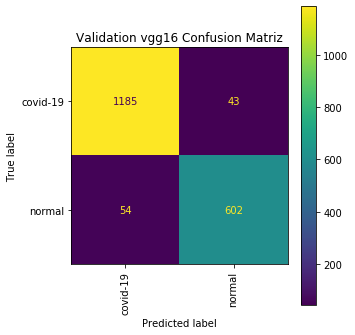

Epochs 2 Validating Accuracy :  94.85  F1 Score :  0.9485


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.035506: : 620it [24:40,  2.39s/it]
63it [00:53,  1.17it/s]


Epochs 3 Training Confusion Martis
[[[ 5962   438]
  [  367 11833]]

 [[11833   367]
  [  438  5962]]

 [[18600     0]
  [    0     0]]]


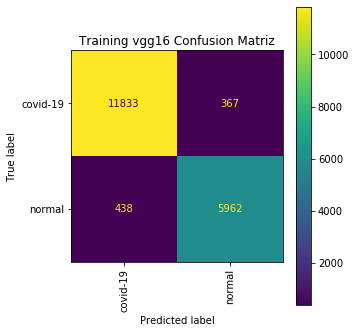

Epochs 3 Training Accuracy :  95.67  F1 Score :  0.9567
Epochs 3 Validation Confusion Martis
[[[ 614   42]
  [  43 1185]]

 [[1185   43]
  [  42  614]]

 [[1884    0]
  [   0    0]]]


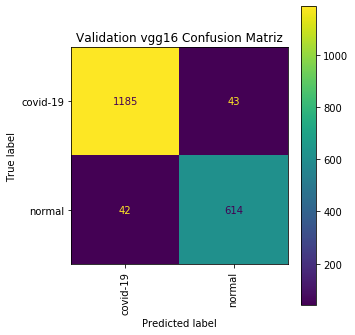

Epochs 3 Validating Accuracy :  95.49  F1 Score :  0.9549


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.070406: : 620it [24:30,  2.37s/it]
63it [00:53,  1.17it/s]


Epochs 4 Training Confusion Martis
[[[ 6033   367]
  [  331 11869]]

 [[11869   331]
  [  367  6033]]

 [[18600     0]
  [    0     0]]]


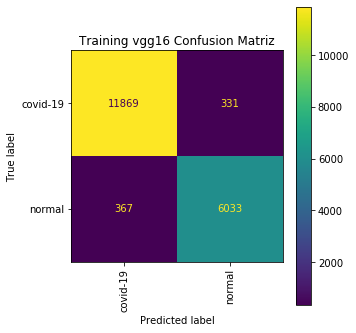

Epochs 4 Training Accuracy :  96.25  F1 Score :  0.9625
Epochs 4 Validation Confusion Martis
[[[ 614   42]
  [  34 1194]]

 [[1194   34]
  [  42  614]]

 [[1884    0]
  [   0    0]]]


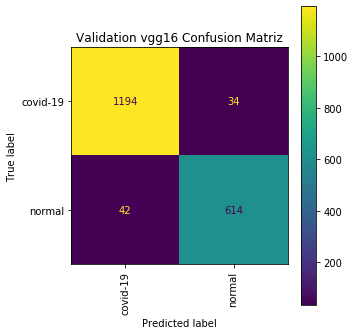

Epochs 4 Validating Accuracy :  95.97  F1 Score :  0.9597


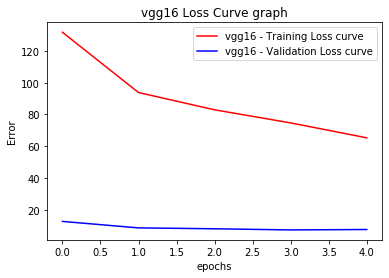

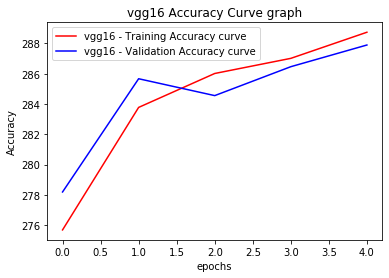

********************** END TRAINING  ******************************


In [9]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = nn.BCEWithLogitsLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelT1V = train(modelT1V,0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)

# ############################## Saving Model  #######################################
pickle.dump(modelT1V, open('vgg16_BCET2V.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [12]:


m = pickle.load(open('vgg16_BCET2V.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "vgg16_BCET2V")


**********************  Testing  ******************************
********************** END Testing  ******************************


##### Test 3 VGG on BCE

In [ ]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 10
features = list()
model_name = "vgg16"

#############################  batch size  = 8        ##############################
batch_size = 15
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelT1V = vgg16_d

############################# Freezing Layer ########################################
modelT1V = freez_layers('none', modelT1V, 'vgg16')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('vgg16', modelT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", model.getModel())
modelT1V = replacelayers(features, modelT1V, 'vgg16')
# print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

In [ ]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = nn.BCEWithLogitsLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelT1V = train(modelT1V, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)

# ############################## Saving Model  #######################################
pickle.dump(modelT1V, open('vgg16_BCET1V.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [ ]:

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(modelT1V, testloader, device, 0.5, "vgg16_BCET1V")

##### Test 1 resnet on BCE

In [12]:

resnet18_d = models.resnet18(pretrained=True)


Epochs = 5
features = list()
model_name = "resnet18"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelBT1V = resnet18_d

############################# Freezing Layer ########################################
modelBT1V = freez_layers('none', modelBT1V, 'resnet18')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('resnet18', modelBT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", modelBT1V)
modelBT1V = replacelayers(features, modelBT1V, 'resnet18')
# print ("After Replaces FCs", modelBT1V)


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.329856: : 620it [04:41,  2.20it/s]
63it [00:11,  5.62it/s]


Epochs 0 Training Confusion Martis
[[[ 5365  1035]
  [  910 11290]]

 [[11290   910]
  [ 1035  5365]]

 [[18600     0]
  [    0     0]]]


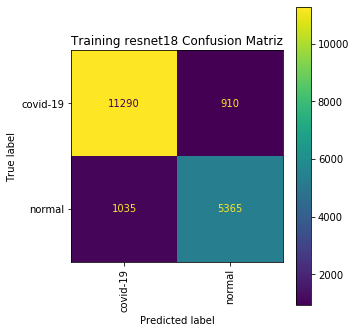

Epochs 0 Training Accuracy :  89.53999999999999  F1 Score :  0.8954
Epochs 0 Validation Confusion Martis
[[[ 560   96]
  [  63 1165]]

 [[1165   63]
  [  96  560]]

 [[1884    0]
  [   0    0]]]


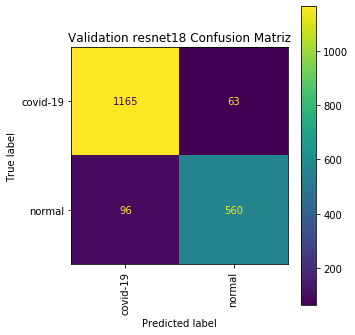

Epochs 0 Validating Accuracy :  91.56  F1 Score :  0.9156


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.334101: : 620it [04:44,  2.18it/s]
63it [00:10,  6.25it/s]


Epochs 1 Training Confusion Martis
[[[ 5644   756]
  [  574 11626]]

 [[11626   574]
  [  756  5644]]

 [[18600     0]
  [    0     0]]]


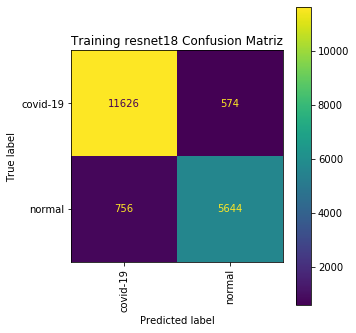

Epochs 1 Training Accuracy :  92.85  F1 Score :  0.9285
Epochs 1 Validation Confusion Martis
[[[ 572   84]
  [  57 1171]]

 [[1171   57]
  [  84  572]]

 [[1884    0]
  [   0    0]]]


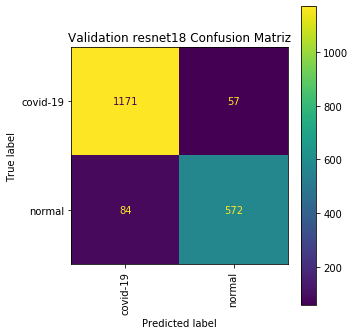

Epochs 1 Validating Accuracy :  92.52  F1 Score :  0.9252


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.234921: : 620it [04:40,  2.21it/s]
63it [00:10,  6.01it/s]


Epochs 2 Training Confusion Martis
[[[ 5746   654]
  [  522 11678]]

 [[11678   522]
  [  654  5746]]

 [[18600     0]
  [    0     0]]]


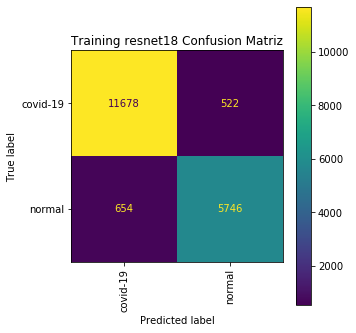

Epochs 2 Training Accuracy :  93.67999999999999  F1 Score :  0.9368
Epochs 2 Validation Confusion Martis
[[[ 588   68]
  [  50 1178]]

 [[1178   50]
  [  68  588]]

 [[1884    0]
  [   0    0]]]


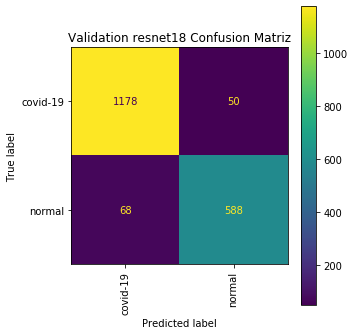

Epochs 2 Validating Accuracy :  93.74  F1 Score :  0.9374


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.192193: : 620it [04:43,  2.19it/s]
63it [00:10,  5.98it/s]


Epochs 3 Training Confusion Martis
[[[ 5812   588]
  [  494 11706]]

 [[11706   494]
  [  588  5812]]

 [[18600     0]
  [    0     0]]]


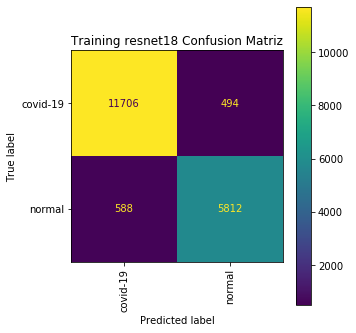

Epochs 3 Training Accuracy :  94.17999999999999  F1 Score :  0.9418
Epochs 3 Validation Confusion Martis
[[[ 594   62]
  [  46 1182]]

 [[1182   46]
  [  62  594]]

 [[1884    0]
  [   0    0]]]


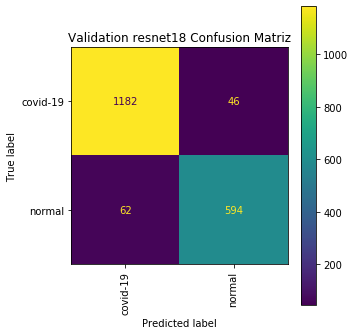

Epochs 3 Validating Accuracy :  94.27  F1 Score :  0.9427


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.171308: : 620it [04:42,  2.19it/s]
63it [00:10,  6.29it/s]


Epochs 4 Training Confusion Martis
[[[ 5889   511]
  [  438 11762]]

 [[11762   438]
  [  511  5889]]

 [[18600     0]
  [    0     0]]]


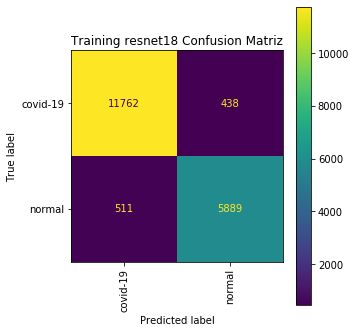

Epochs 4 Training Accuracy :  94.89999999999999  F1 Score :  0.949
Epochs 4 Validation Confusion Martis
[[[ 609   47]
  [  35 1193]]

 [[1193   35]
  [  47  609]]

 [[1884    0]
  [   0    0]]]


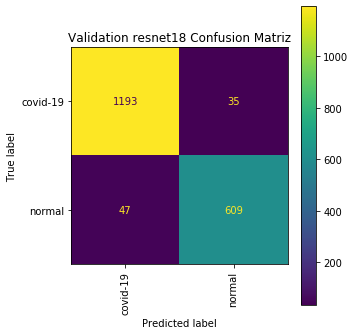

Epochs 4 Validating Accuracy :  95.65  F1 Score :  0.9565


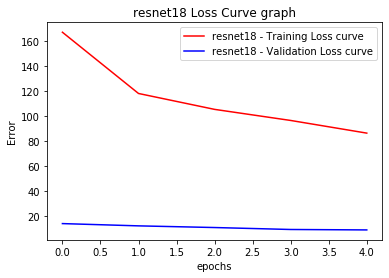

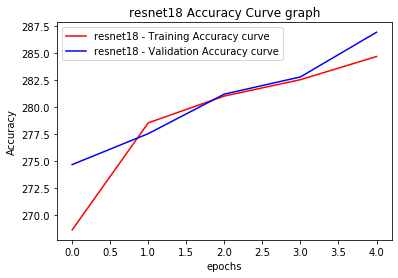

********************** END TRAINING  ******************************


NameError: name 'modelT1V' is not defined

In [14]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelBT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = nn.BCEWithLogitsLoss()

############################## Training Model ######################################
modelBT1V = train(modelBT1V, 0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)

# ############################## Saving Model  #######################################
pickle.dump(modelBT1V, open('resnet18_BCET1.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [15]:

m = pickle.load(open('resnet18_BCET1.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "Resnet18_T1")


**********************  Testing  ******************************
********************** END Testing  ******************************


##### Test 2resnet on BCE

In [7]:

resnet18_d = models.resnet18(pretrained=True)


Epochs = 5
features = list()
model_name = "resnet18"

#############################  batch size  = 10        ##############################
batch_size = 10
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelT1V = resnet18_d

############################# Freezing Layer ########################################
modelT1V = freez_layers('none', modelT1V, 'resnet18')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('resnet18', modelT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 1360 )])
# Adding last layer 
features.extend([nn.Linear(1360, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", modelT1V)
modelT1V = replacelayers(features, modelT1V, 'resnet18')
# print ("After Replaces FCs", modelT1V)


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=512, out_features=1360, bias=True), Linear(in_features=1360, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.095938: : 620it [04:41,  2.21it/s]
63it [00:09,  6.32it/s]


Epochs 0 Training Confusion Martis
[[[ 5332  1068]
  [  903 11297]]

 [[11297   903]
  [ 1068  5332]]

 [[18600     0]
  [    0     0]]]


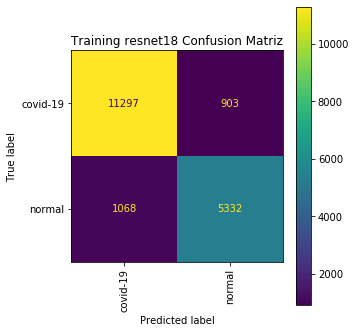

Epochs 0 Training Accuracy :  89.4  F1 Score :  0.894
Epochs 0 Validation Confusion Martis
[[[ 568   88]
  [  62 1166]]

 [[1166   62]
  [  88  568]]

 [[1884    0]
  [   0    0]]]


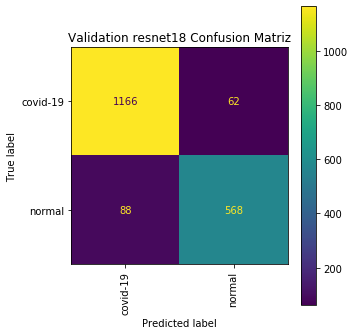

Epochs 0 Validating Accuracy :  92.04  F1 Score :  0.9204


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.089037: : 620it [05:37,  1.83it/s]
63it [00:10,  5.95it/s]


Epochs 1 Training Confusion Martis
[[[ 5599   801]
  [  613 11587]]

 [[11587   613]
  [  801  5599]]

 [[18600     0]
  [    0     0]]]


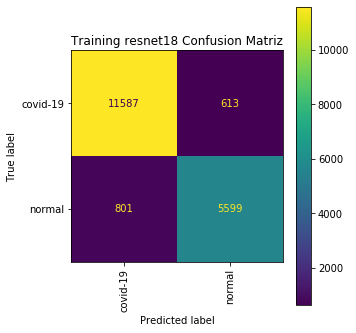

Epochs 1 Training Accuracy :  92.4  F1 Score :  0.924
Epochs 1 Validation Confusion Martis
[[[ 576   80]
  [  53 1175]]

 [[1175   53]
  [  80  576]]

 [[1884    0]
  [   0    0]]]


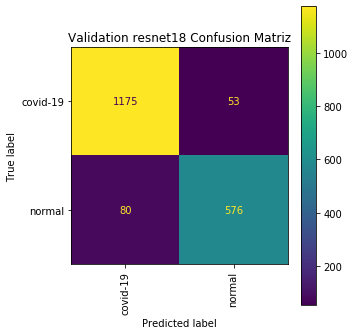

Epochs 1 Validating Accuracy :  92.94  F1 Score :  0.9294


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.152184: : 620it [06:30,  1.59it/s]
63it [00:10,  5.92it/s]


Epochs 2 Training Confusion Martis
[[[ 5721   679]
  [  544 11656]]

 [[11656   544]
  [  679  5721]]

 [[18600     0]
  [    0     0]]]


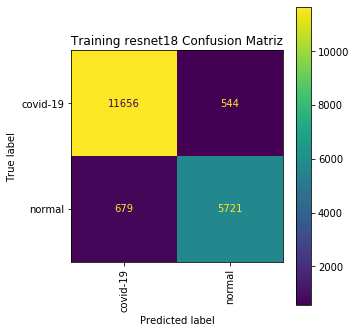

Epochs 2 Training Accuracy :  93.42  F1 Score :  0.9342
Epochs 2 Validation Confusion Martis
[[[ 584   72]
  [  48 1180]]

 [[1180   48]
  [  72  584]]

 [[1884    0]
  [   0    0]]]


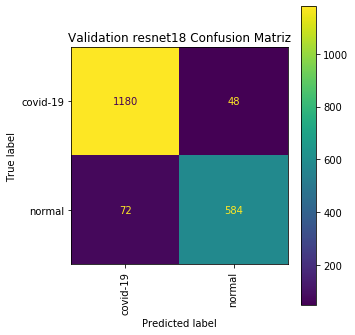

Epochs 2 Validating Accuracy :  93.63  F1 Score :  0.9363


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.238850: : 620it [06:31,  1.58it/s]
63it [00:09,  6.47it/s]


Epochs 3 Training Confusion Martis
[[[ 5825   575]
  [  473 11727]]

 [[11727   473]
  [  575  5825]]

 [[18600     0]
  [    0     0]]]


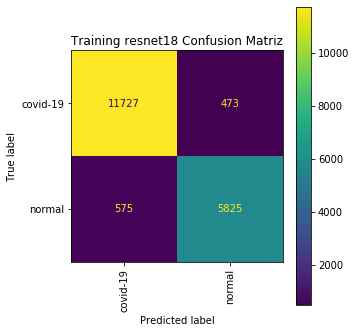

Epochs 3 Training Accuracy :  94.37  F1 Score :  0.9437
Epochs 3 Validation Confusion Martis
[[[ 592   64]
  [  55 1173]]

 [[1173   55]
  [  64  592]]

 [[1884    0]
  [   0    0]]]


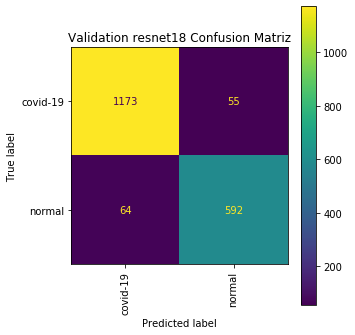

Epochs 3 Validating Accuracy :  93.67999999999999  F1 Score :  0.9368


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.083117: : 620it [04:43,  2.19it/s]
63it [00:10,  6.16it/s]


Epochs 4 Training Confusion Martis
[[[ 5870   530]
  [  452 11748]]

 [[11748   452]
  [  530  5870]]

 [[18600     0]
  [    0     0]]]


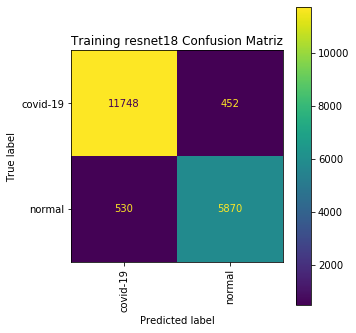

Epochs 4 Training Accuracy :  94.72  F1 Score :  0.9472
Epochs 4 Validation Confusion Martis
[[[ 598   58]
  [  45 1183]]

 [[1183   45]
  [  58  598]]

 [[1884    0]
  [   0    0]]]


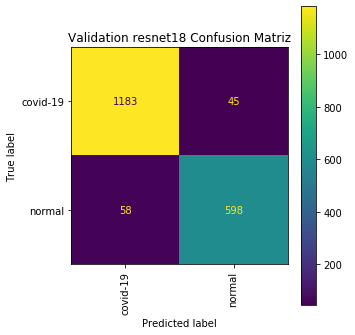

Epochs 4 Validating Accuracy :  94.53  F1 Score :  0.9453


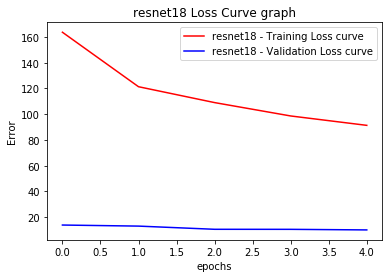

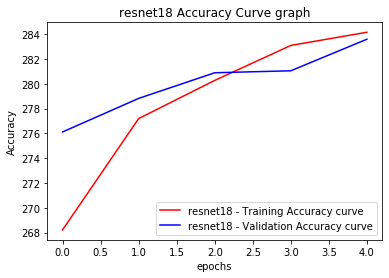

********************** END TRAINING  ******************************


In [8]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = nn.BCEWithLogitsLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelT1V = train(modelT1V,0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)

# ############################## Saving Model  #######################################
pickle.dump(modelT1V, open('resnet18_BCET2.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [9]:


m = pickle.load(open('resnet18_BCET2.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "Resnet18_T2")


**********************  Testing  ******************************
********************** END Testing  ******************************


##### Test 3 resnet on BCE

In [ ]:

resnet18_d = models.resnet18(pretrained=True)


Epochs = 10
features = list()
model_name = "resnet18"

#############################  batch size  = 8        ##############################
batch_size = 15
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelT1R = resnet18_d

############################# Freezing Layer ########################################
modelT1R = freez_layers('none', modelT1R, 'resnet18')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('resnet18', modelT1R)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", model.getModel())
modelT1R = replacelayers(features, modelT1R, 'resnet18')
# print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

In [ ]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelT1R.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = nn.BCEWithLogitsLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelT1R = train(modelT1R, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)

# ############################## Saving Model  #######################################
pickle.dump(modelT1R, open('Resnet_BCET3.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [ ]:

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(modelT1R, testloader, device, 0.5, "Resnet_BCET3")


# Focal Loss Testing

##### Focal Loss Test 1 VGG16

In [ ]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
features = list()
model_name = "vgg16"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelFT1V = vgg16_d

############################# Freezing Layer ########################################
modelFT1V = freez_layers('none', modelFT1V, 'vgg16')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('vgg16', modelFT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", modelFT1R)
modelFT1V = replacelayers(features, modelFT1V, 'vgg16')
# print ("After Replaces FCs", modelFT1R)


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

In [ ]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelFT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = FocalLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelFT1V = train(modelFT1V, trainloader,validloader, optimizer, Epochs, criterion, device, model_name+" Focal Loss")

# ############################## Saving Model  #######################################
pickle.dump(modelFT1V, open('vgg16_FocalLossT1.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [ ]:


m = pickle.load(open('vgg16_FocalLossT1.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "vgg16_FocalLossT1")


##### Focal Loss Test 2 Vgg16

In [7]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 5
features = list()
model_name = "vgg16"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelFT2V = vgg16_d

############################# Freezing Layer ########################################
modelFT2V = freez_layers('none', modelFT2V, 'vgg16')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('vgg16', modelFT2V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", modelFT1R)
modelFT2V = replacelayers(features, modelFT2V, 'vgg16')
# print ("After Replaces FCs", modelFT1R)


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=25088, out_features=680, bias=True), Linear(in_features=680, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


0it [00:00, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.004946: : 620it [21:25,  2.07s/it]
63it [00:38,  1.62it/s]


Epochs 0 Training Confusion Martis
[[[ 5430   970]
  [  796 11404]]

 [[11404   796]
  [  970  5430]]

 [[18600     0]
  [    0     0]]]


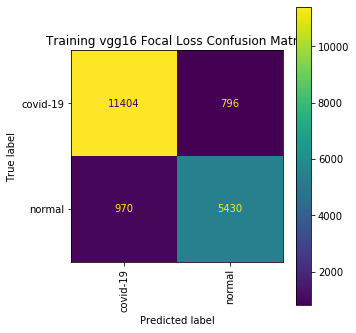

Epochs 0 Training Accuracy :  90.51  F1 Score :  0.9051
Epochs 0 Validation Confusion Martis
[[[ 577   79]
  [  58 1170]]

 [[1170   58]
  [  79  577]]

 [[1884    0]
  [   0    0]]]


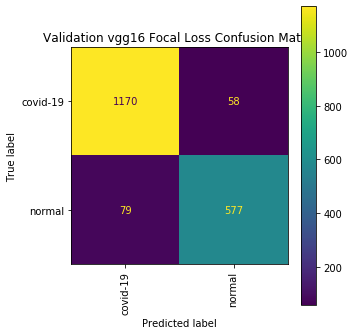

Epochs 0 Validating Accuracy :  92.73  F1 Score :  0.9273


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.003601: : 620it [20:44,  2.01s/it]
63it [00:38,  1.64it/s]


Epochs 1 Training Confusion Martis
[[[ 5729   671]
  [  524 11676]]

 [[11676   524]
  [  671  5729]]

 [[18600     0]
  [    0     0]]]


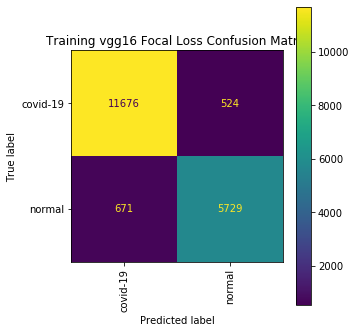

Epochs 1 Training Accuracy :  93.58  F1 Score :  0.9358
Epochs 1 Validation Confusion Martis
[[[ 589   67]
  [  53 1175]]

 [[1175   53]
  [  67  589]]

 [[1884    0]
  [   0    0]]]


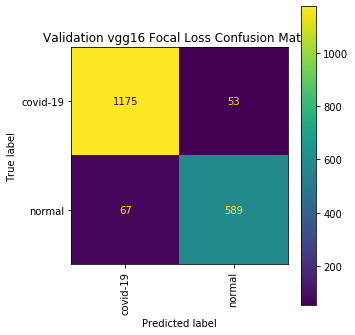

Epochs 1 Validating Accuracy :  93.63  F1 Score :  0.9363


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.009152: : 620it [20:33,  1.99s/it]
63it [00:38,  1.63it/s]


Epochs 2 Training Confusion Martis
[[[ 5829   571]
  [  469 11731]]

 [[11731   469]
  [  571  5829]]

 [[18600     0]
  [    0     0]]]


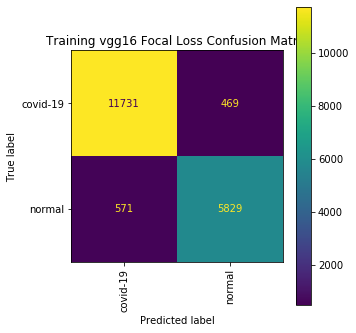

Epochs 2 Training Accuracy :  94.41000000000001  F1 Score :  0.9441
Epochs 2 Validation Confusion Martis
[[[ 600   56]
  [  47 1181]]

 [[1181   47]
  [  56  600]]

 [[1884    0]
  [   0    0]]]


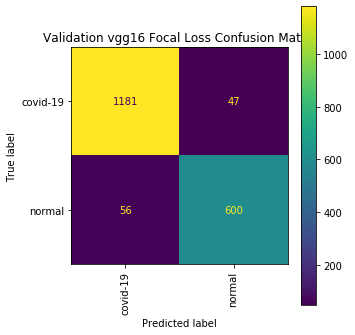

Epochs 2 Validating Accuracy :  94.53  F1 Score :  0.9453


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.008242: : 620it [20:43,  2.01s/it]
63it [00:38,  1.63it/s]


Epochs 3 Training Confusion Martis
[[[ 5860   540]
  [  454 11746]]

 [[11746   454]
  [  540  5860]]

 [[18600     0]
  [    0     0]]]


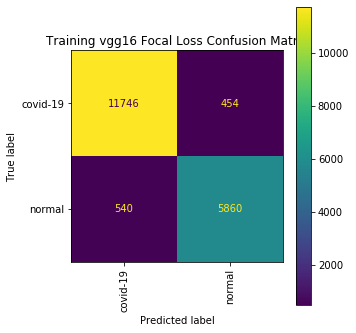

Epochs 3 Training Accuracy :  94.66  F1 Score :  0.9466
Epochs 3 Validation Confusion Martis
[[[ 597   59]
  [  48 1180]]

 [[1180   48]
  [  59  597]]

 [[1884    0]
  [   0    0]]]


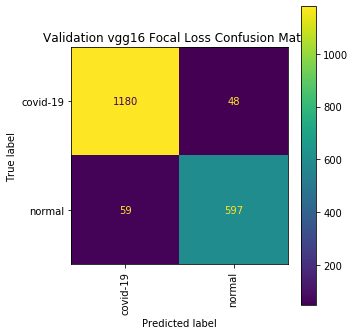

Epochs 3 Validating Accuracy :  94.32000000000001  F1 Score :  0.9432


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.004365: : 620it [20:35,  1.99s/it]
63it [00:38,  1.62it/s]


Epochs 4 Training Confusion Martis
[[[ 5946   454]
  [  385 11815]]

 [[11815   385]
  [  454  5946]]

 [[18600     0]
  [    0     0]]]


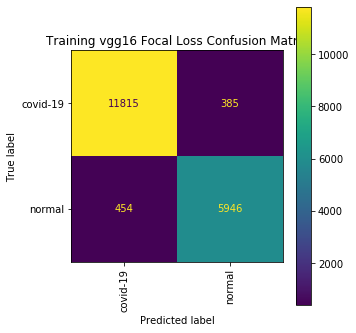

Epochs 4 Training Accuracy :  95.49  F1 Score :  0.9549
Epochs 4 Validation Confusion Martis
[[[ 607   49]
  [  44 1184]]

 [[1184   44]
  [  49  607]]

 [[1884    0]
  [   0    0]]]


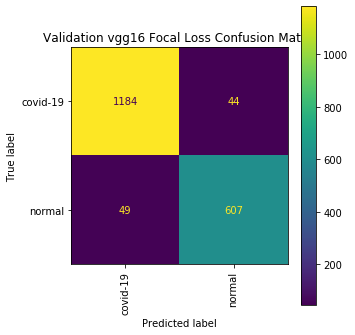

Epochs 4 Validating Accuracy :  95.06  F1 Score :  0.9506


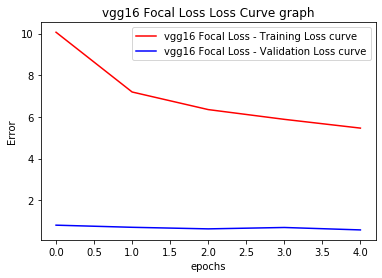

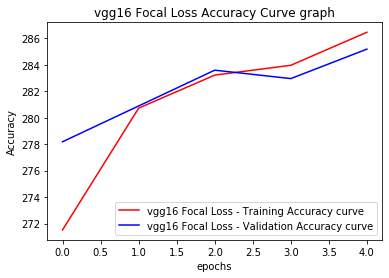

********************** END TRAINING  ******************************


In [8]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelFT2V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = FocalLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelFT2V = train(modelFT2V, 0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name+" Focal Loss")

# ############################## Saving Model  #######################################
pickle.dump(modelFT2V, open('vgg16_FocalLossT2.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [ ]:


m = pickle.load(open('vgg16_FocalLossT2.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "vgg16_FocalLossT2")


##### Focal Loss Test 3 Vgg16

In [ ]:

vgg16_d = models.vgg16(pretrained=True)


Epochs = 10
features = list()
model_name = "vgg16"

#############################  batch size  = 8        ##############################
batch_size = 15
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelT1V = vgg16_d

############################# Freezing Layer ########################################
modelT1V = freez_layers('none', modelT1V, 'vgg16')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('vgg16', modelT1V)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", model.getModel())
modelT1V = replacelayers(features, modelT1V, 'vgg16')
# print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

In [ ]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelT1V.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = FocalLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelT1V = train(modelT1V, trainloader,validloader, optimizer, Epochs, criterion, device, model_name+" Focal Loss ")

# ############################## Saving Model  #######################################
path = F"/content/gdrive/My Drive/A_05_Part_02_Dataset/vgg16_FocalLossT3.pth" 
torch.save(modelT1V.state_dict(), path)

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [ ]:

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(modelT1V, testloader, device, 0.5, "vgg16_FocalLossT1")


##### Focal Loss Test 1 Resnet18

In [7]:

resnet18_d = models.resnet18(pretrained=True)


Epochs = 5
features = list()
model_name = "resnet18"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.001   ##############################
learning_rate = 0.001

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelFT1R = resnet18_d

############################# Freezing Layer ########################################
modelFT1R = freez_layers('none', modelFT1R, 'resnet18')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('resnet18', modelFT1R)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", modelFT1R)
modelFT1R = replacelayers(features, modelFT1R, 'resnet18')
# print ("After Replaces FCs", modelFT1R)


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


0it [00:00, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.020805: : 620it [04:40,  2.21it/s]
63it [00:09,  6.42it/s]


Epochs 0 Training Confusion Martis
[[[ 4882  1518]
  [ 1430 10770]]

 [[10770  1430]
  [ 1518  4882]]

 [[18600     0]
  [    0     0]]]


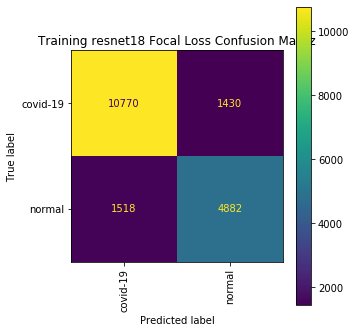

Epochs 0 Training Accuracy :  84.15  F1 Score :  0.8415
Epochs 0 Validation Confusion Martis
[[[ 545  111]
  [  91 1137]]

 [[1137   91]
  [ 111  545]]

 [[1884    0]
  [   0    0]]]


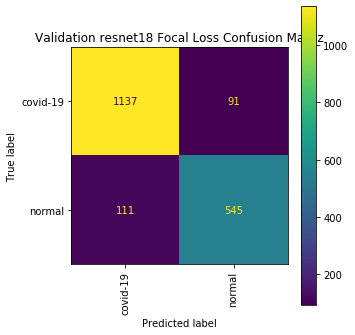

Epochs 0 Validating Accuracy :  89.28  F1 Score :  0.8928


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.007661: : 620it [04:39,  2.22it/s]
63it [00:10,  6.08it/s]


Epochs 1 Training Confusion Martis
[[[ 5387  1013]
  [  844 11356]]

 [[11356   844]
  [ 1013  5387]]

 [[18600     0]
  [    0     0]]]


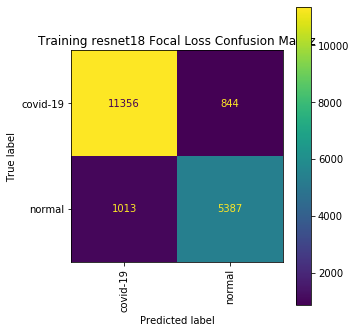

Epochs 1 Training Accuracy :  90.02  F1 Score :  0.9002
Epochs 1 Validation Confusion Martis
[[[ 552  104]
  [  75 1153]]

 [[1153   75]
  [ 104  552]]

 [[1884    0]
  [   0    0]]]


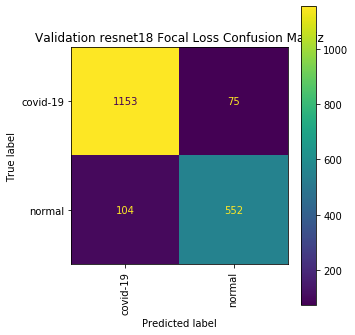

Epochs 1 Validating Accuracy :  90.5  F1 Score :  0.905


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.023304: : 620it [04:40,  2.21it/s]
63it [00:10,  6.15it/s]


Epochs 2 Training Confusion Martis
[[[ 5473   927]
  [  729 11471]]

 [[11471   729]
  [  927  5473]]

 [[18600     0]
  [    0     0]]]


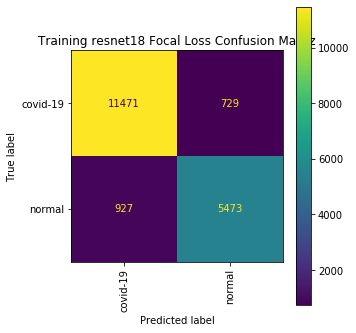

Epochs 2 Training Accuracy :  91.10000000000001  F1 Score :  0.911
Epochs 2 Validation Confusion Martis
[[[ 548  108]
  [  82 1146]]

 [[1146   82]
  [ 108  548]]

 [[1884    0]
  [   0    0]]]


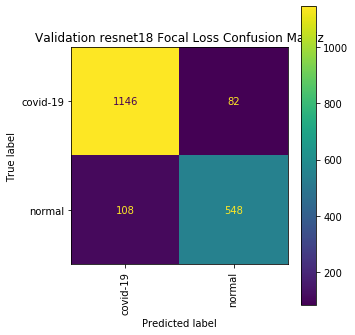

Epochs 2 Validating Accuracy :  89.92  F1 Score :  0.8992


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.007936: : 620it [04:40,  2.21it/s]
63it [00:09,  6.36it/s]


Epochs 3 Training Confusion Martis
[[[ 5519   881]
  [  682 11518]]

 [[11518   682]
  [  881  5519]]

 [[18600     0]
  [    0     0]]]


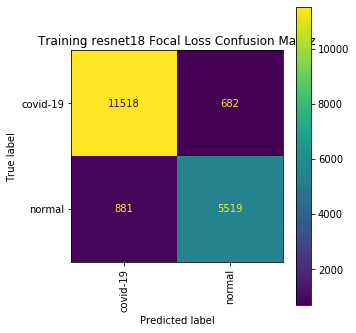

Epochs 3 Training Accuracy :  91.60000000000001  F1 Score :  0.916
Epochs 3 Validation Confusion Martis
[[[ 563   93]
  [  62 1166]]

 [[1166   62]
  [  93  563]]

 [[1884    0]
  [   0    0]]]


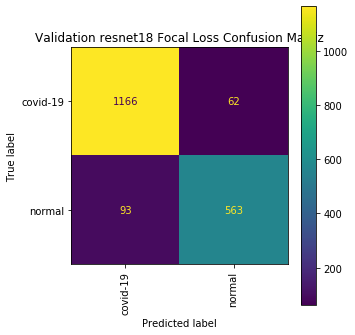

Epochs 3 Validating Accuracy :  91.77  F1 Score :  0.9177


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.005199: : 620it [04:42,  2.20it/s]
63it [00:09,  6.41it/s]


Epochs 4 Training Confusion Martis
[[[ 5567   833]
  [  630 11570]]

 [[11570   630]
  [  833  5567]]

 [[18600     0]
  [    0     0]]]


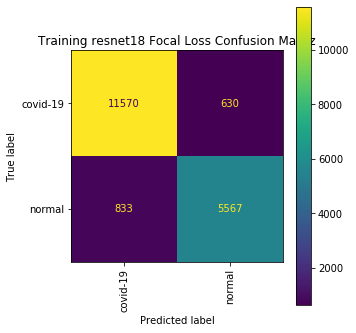

Epochs 4 Training Accuracy :  92.13  F1 Score :  0.9213
Epochs 4 Validation Confusion Martis
[[[ 563   93]
  [  69 1159]]

 [[1159   69]
  [  93  563]]

 [[1884    0]
  [   0    0]]]


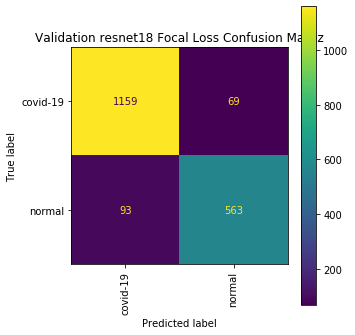

Epochs 4 Validating Accuracy :  91.4  F1 Score :  0.914


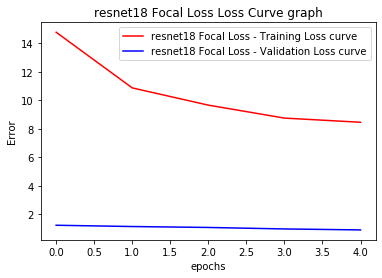

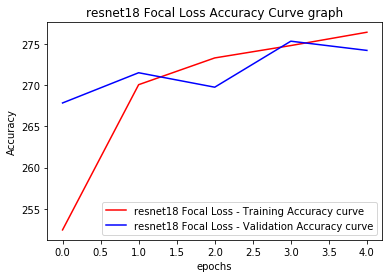

********************** END TRAINING  ******************************


In [8]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelFT1R.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = FocalLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelFT1R = train(modelFT1R,0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name+" Focal Loss")

# ############################## Saving Model  #######################################
pickle.dump(modelFT1R, open('resnet18_FocalLossT1.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [9]:


m = pickle.load(open('resnet18_FocalLossT1.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "resnet18_FocalLossT1")


**********************  Testing  ******************************
********************** END Testing  ******************************


##### Focal Loss Test 2 Resnet18

In [7]:

resnet18_d = models.resnet18(pretrained=True)


Epochs = 5
features = list()
model_name = "resnet18"

#############################  batch size  = 8        ##############################
batch_size = 10
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelFT2R = resnet18_d

############################# Freezing Layer ########################################
modelFT2R = freez_layers('none', modelFT2R, 'resnet18')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('resnet18', modelFT2R)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", modelFT1R)
modelFT2R = replacelayers(features, modelFT2R, 'resnet18')
# print ("After Replaces FCs", modelFT1R)


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


0it [00:00, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.012634: : 620it [04:49,  2.14it/s]
63it [00:09,  6.35it/s]


Epochs 0 Training Confusion Martis
[[[ 4686  1714]
  [ 1375 10825]]

 [[10825  1375]
  [ 1714  4686]]

 [[18600     0]
  [    0     0]]]


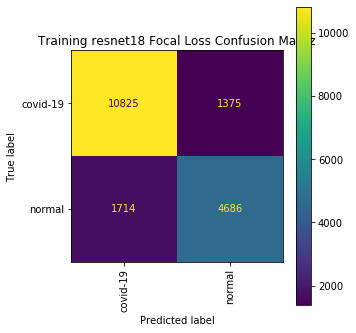

Epochs 0 Training Accuracy :  83.39  F1 Score :  0.8339
Epochs 0 Validation Confusion Martis
[[[ 515  141]
  [ 102 1126]]

 [[1126  102]
  [ 141  515]]

 [[1884    0]
  [   0    0]]]


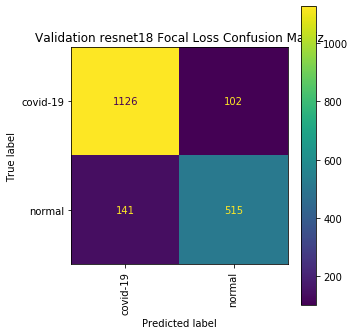

Epochs 0 Validating Accuracy :  87.1  F1 Score :  0.871


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.009464: : 620it [04:42,  2.20it/s]
63it [00:10,  5.84it/s]


Epochs 1 Training Confusion Martis
[[[ 5257  1143]
  [  928 11272]]

 [[11272   928]
  [ 1143  5257]]

 [[18600     0]
  [    0     0]]]


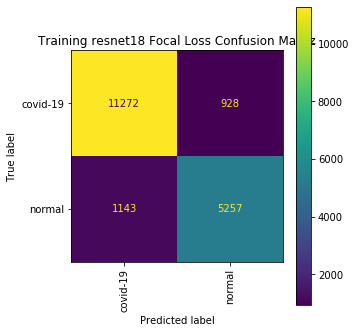

Epochs 1 Training Accuracy :  88.87  F1 Score :  0.8887
Epochs 1 Validation Confusion Martis
[[[ 542  114]
  [  87 1141]]

 [[1141   87]
  [ 114  542]]

 [[1884    0]
  [   0    0]]]


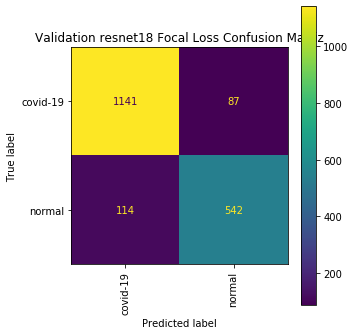

Epochs 1 Validating Accuracy :  89.33  F1 Score :  0.8933


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.014441: : 620it [04:43,  2.19it/s]
63it [00:09,  6.51it/s]


Epochs 2 Training Confusion Martis
[[[ 5417   983]
  [  777 11423]]

 [[11423   777]
  [  983  5417]]

 [[18600     0]
  [    0     0]]]


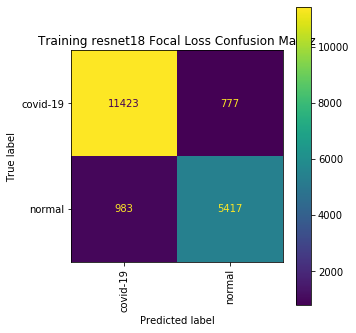

Epochs 2 Training Accuracy :  90.53999999999999  F1 Score :  0.9054
Epochs 2 Validation Confusion Martis
[[[ 551  105]
  [  75 1153]]

 [[1153   75]
  [ 105  551]]

 [[1884    0]
  [   0    0]]]


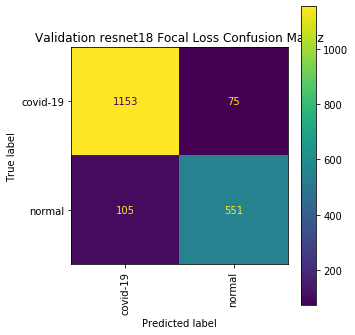

Epochs 2 Validating Accuracy :  90.45  F1 Score :  0.9045


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.021874: : 620it [04:44,  2.18it/s]
63it [00:09,  6.48it/s]


Epochs 3 Training Confusion Martis
[[[ 5504   896]
  [  697 11503]]

 [[11503   697]
  [  896  5504]]

 [[18600     0]
  [    0     0]]]


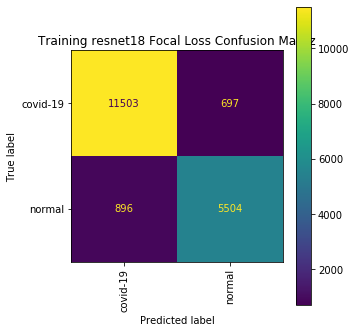

Epochs 3 Training Accuracy :  91.44  F1 Score :  0.9144
Epochs 3 Validation Confusion Martis
[[[ 565   91]
  [  71 1157]]

 [[1157   71]
  [  91  565]]

 [[1884    0]
  [   0    0]]]


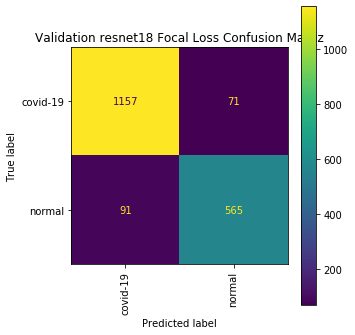

Epochs 3 Validating Accuracy :  91.4  F1 Score :  0.914


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.005085: : 620it [04:51,  2.13it/s]
63it [00:10,  5.99it/s]


Epochs 4 Training Confusion Martis
[[[ 5550   850]
  [  655 11545]]

 [[11545   655]
  [  850  5550]]

 [[18600     0]
  [    0     0]]]


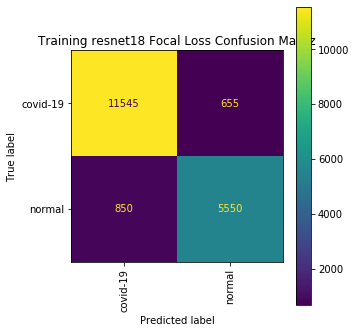

Epochs 4 Training Accuracy :  91.91  F1 Score :  0.9191
Epochs 4 Validation Confusion Martis
[[[ 561   95]
  [  67 1161]]

 [[1161   67]
  [  95  561]]

 [[1884    0]
  [   0    0]]]


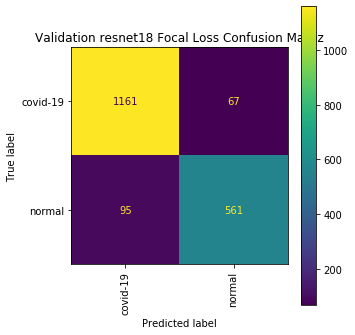

Epochs 4 Validating Accuracy :  91.4  F1 Score :  0.914


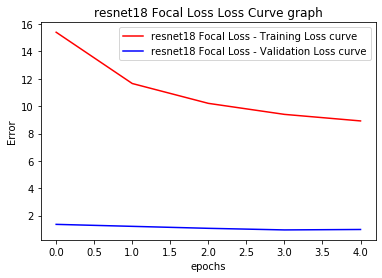

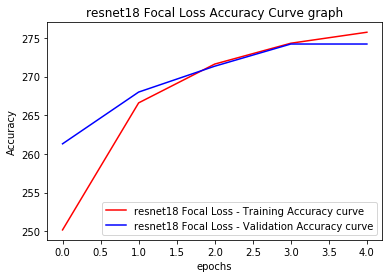

********************** END TRAINING  ******************************


In [9]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelFT2R.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = FocalLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelFT2R = train(modelFT2R,0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name+" Focal Loss")

# ############################## Saving Model  #######################################
pickle.dump(modelFT2R, open('resnet18_FocalLossT2.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [ ]:


m = pickle.load(open('resnet18_FocalLossT2.pth', 'rb'))
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(m, testloader, device, 0.5, "resnet18_FocalLossT2")


##### Focal Loss Test 3 Resnet18

In [7]:

resnet18_d = models.resnet18(pretrained=True)


Epochs = 10
features = list()
model_name = "resnet18"

#############################  batch size  = 8        ##############################
batch_size = 15
#############################  Learning Rate  = 0.0008   ##############################
learning_rate = 0.0008

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers= 4)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers= 4)

############################# Initializing Model ####################################
modelFT3R = resnet18_d

############################# Freezing Layer ########################################
modelFT3R = freez_layers('none', modelFT3R, 'resnet18')

#################### getting last layer input features ##############################
num_features = get_classifier_in_features('resnet18', modelFT3R)

####################### Creating Classification Layers ##############################

# Adding Second Last layer
features.extend([nn.Linear(num_features, 680 )])
# Adding last layer 
features.extend([nn.Linear(680, len(class_names))])
print (features)


####################### Replacing Classification Layers #############################
# print ("before Replaces FCs", model.getModel())
modelFT3R = replacelayers(features, modelFT3R, 'resnet18')
# print ("before Replaces FCs", model.getModel())


####################### Checking Is Cuda available #################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(device)

Layers freezed = NONE
[Linear(in_features=512, out_features=680, bias=True), Linear(in_features=680, out_features=3, bias=True)]
cuda:0


**********************  TRAINING  ******************************
running on GPU


0it [00:00, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [2065/6200 (100%)]	Loss: 0.021897: : 414it [03:47,  1.82it/s]
42it [00:11,  3.81it/s]


Epochs 0 Training Confusion Martis
[[[ 4650  1750]
  [ 1491 10709]]

 [[10709  1491]
  [ 1750  4650]]

 [[18600     0]
  [    0     0]]]


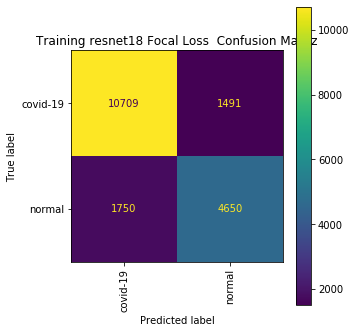

Epochs 0 Training Accuracy :  82.58  F1 Score :  0.8258
Epochs 0 Validation Confusion Martis
[[[ 533  123]
  [  97 1131]]

 [[1131   97]
  [ 123  533]]

 [[1884    0]
  [   0    0]]]


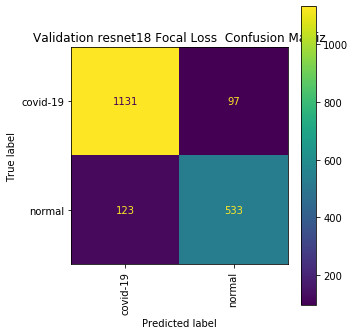

Epochs 0 Validating Accuracy :  88.32  F1 Score :  0.8832


Train Epoch: 1 [2065/6200 (100%)]	Loss: 0.016466: : 414it [03:49,  1.81it/s]
42it [00:10,  4.01it/s]


Epochs 1 Training Confusion Martis
[[[ 5304  1096]
  [  876 11324]]

 [[11324   876]
  [ 1096  5304]]

 [[18600     0]
  [    0     0]]]


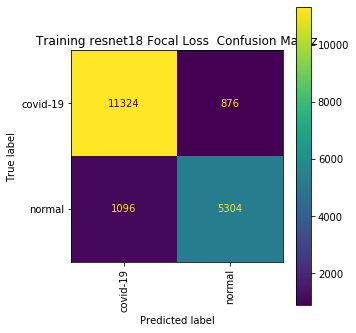

Epochs 1 Training Accuracy :  89.4  F1 Score :  0.894
Epochs 1 Validation Confusion Martis
[[[ 543  113]
  [  84 1144]]

 [[1144   84]
  [ 113  543]]

 [[1884    0]
  [   0    0]]]


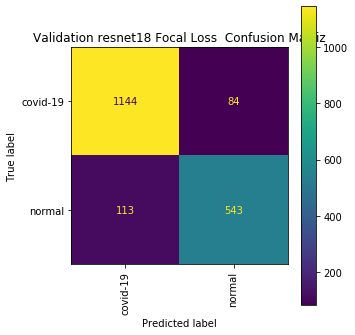

Epochs 1 Validating Accuracy :  89.53999999999999  F1 Score :  0.8954


Train Epoch: 2 [2065/6200 (100%)]	Loss: 0.007023: : 414it [03:49,  1.80it/s]
42it [00:10,  4.15it/s]


Epochs 2 Training Confusion Martis
[[[ 5423   977]
  [  787 11413]]

 [[11413   787]
  [  977  5423]]

 [[18600     0]
  [    0     0]]]


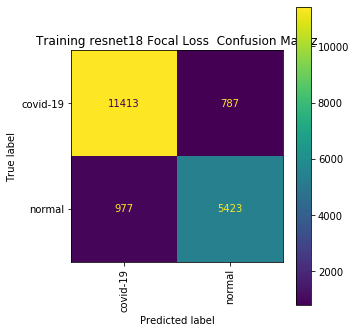

Epochs 2 Training Accuracy :  90.52  F1 Score :  0.9052
Epochs 2 Validation Confusion Martis
[[[ 566   90]
  [  77 1151]]

 [[1151   77]
  [  90  566]]

 [[1884    0]
  [   0    0]]]


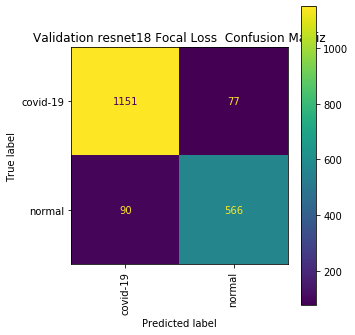

Epochs 2 Validating Accuracy :  91.14  F1 Score :  0.9114


Train Epoch: 3 [2065/6200 (100%)]	Loss: 0.020490: : 414it [03:50,  1.80it/s]
42it [00:10,  4.17it/s]


Epochs 3 Training Confusion Martis
[[[ 5502   898]
  [  705 11495]]

 [[11495   705]
  [  898  5502]]

 [[18600     0]
  [    0     0]]]


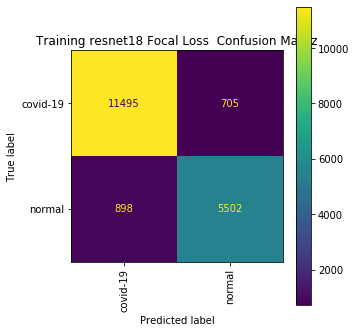

Epochs 3 Training Accuracy :  91.38  F1 Score :  0.9138
Epochs 3 Validation Confusion Martis
[[[ 566   90]
  [  63 1165]]

 [[1165   63]
  [  90  566]]

 [[1884    0]
  [   0    0]]]


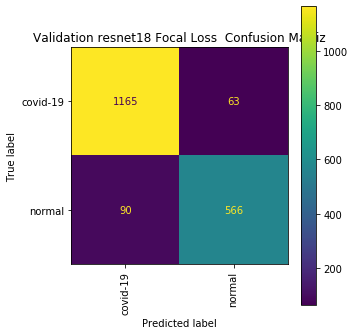

Epochs 3 Validating Accuracy :  91.88  F1 Score :  0.9188


Train Epoch: 4 [2065/6200 (100%)]	Loss: 0.009090: : 414it [03:53,  1.77it/s]
42it [00:12,  3.50it/s]


Epochs 4 Training Confusion Martis
[[[ 5545   855]
  [  673 11527]]

 [[11527   673]
  [  855  5545]]

 [[18600     0]
  [    0     0]]]


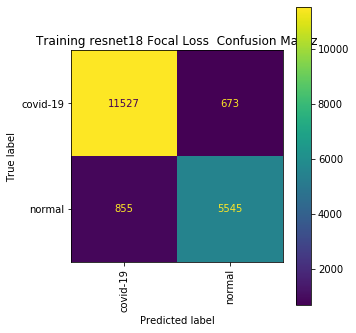

Epochs 4 Training Accuracy :  91.78  F1 Score :  0.9178
Epochs 4 Validation Confusion Martis
[[[ 561   95]
  [  72 1156]]

 [[1156   72]
  [  95  561]]

 [[1884    0]
  [   0    0]]]


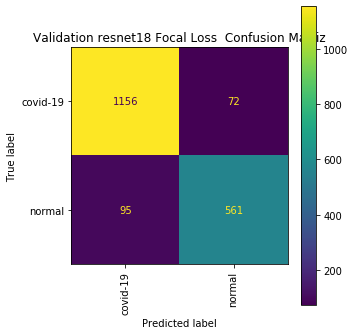

Epochs 4 Validating Accuracy :  91.14  F1 Score :  0.9114


Train Epoch: 5 [2065/6200 (100%)]	Loss: 0.009652: : 414it [03:58,  1.74it/s]
42it [00:11,  3.51it/s]


Epochs 5 Training Confusion Martis
[[[ 5563   837]
  [  637 11563]]

 [[11563   637]
  [  837  5563]]

 [[18600     0]
  [    0     0]]]


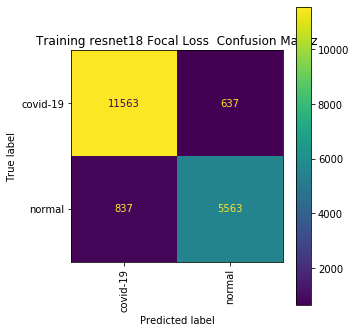

Epochs 5 Training Accuracy :  92.08  F1 Score :  0.9208
Epochs 5 Validation Confusion Martis
[[[ 560   96]
  [  67 1161]]

 [[1161   67]
  [  96  560]]

 [[1884    0]
  [   0    0]]]


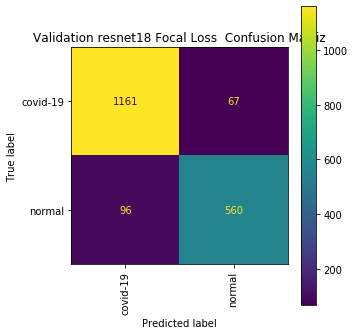

Epochs 5 Validating Accuracy :  91.35  F1 Score :  0.9135


Train Epoch: 6 [2065/6200 (100%)]	Loss: 0.006435: : 414it [04:06,  1.68it/s]
42it [00:10,  4.01it/s]


Epochs 6 Training Confusion Martis
[[[ 5600   800]
  [  600 11600]]

 [[11600   600]
  [  800  5600]]

 [[18600     0]
  [    0     0]]]


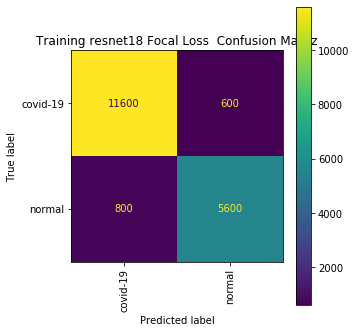

Epochs 6 Training Accuracy :  92.47  F1 Score :  0.9247
Epochs 6 Validation Confusion Martis
[[[ 570   86]
  [  59 1169]]

 [[1169   59]
  [  86  570]]

 [[1884    0]
  [   0    0]]]


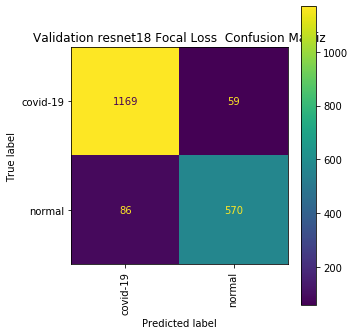

Epochs 6 Validating Accuracy :  92.30000000000001  F1 Score :  0.923


Train Epoch: 7 [2065/6200 (100%)]	Loss: 0.010363: : 414it [04:05,  1.69it/s]
42it [00:10,  4.11it/s]


Epochs 7 Training Confusion Martis
[[[ 5641   759]
  [  558 11642]]

 [[11642   558]
  [  759  5641]]

 [[18600     0]
  [    0     0]]]


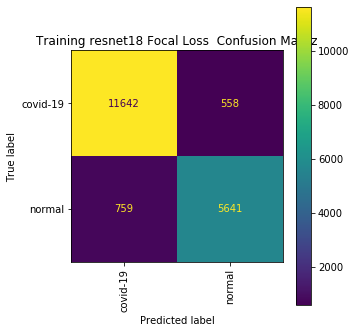

Epochs 7 Training Accuracy :  92.92  F1 Score :  0.9292
Epochs 7 Validation Confusion Martis
[[[ 570   86]
  [  55 1173]]

 [[1173   55]
  [  86  570]]

 [[1884    0]
  [   0    0]]]


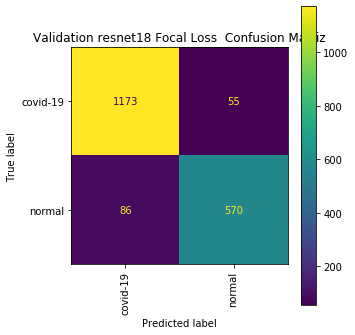

Epochs 7 Validating Accuracy :  92.52  F1 Score :  0.9252


Train Epoch: 8 [2065/6200 (100%)]	Loss: 0.001375: : 414it [04:03,  1.70it/s]
42it [00:11,  3.64it/s]


Epochs 8 Training Confusion Martis
[[[ 5659   741]
  [  556 11644]]

 [[11644   556]
  [  741  5659]]

 [[18600     0]
  [    0     0]]]


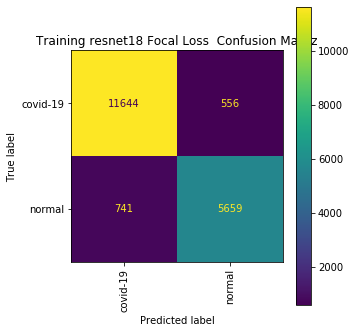

Epochs 8 Training Accuracy :  93.03  F1 Score :  0.9303
Epochs 8 Validation Confusion Martis
[[[ 573   83]
  [  58 1170]]

 [[1170   58]
  [  83  573]]

 [[1884    0]
  [   0    0]]]


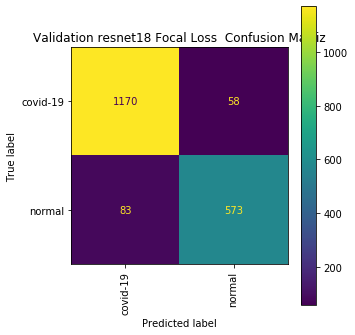

Epochs 8 Validating Accuracy :  92.52  F1 Score :  0.9252


Train Epoch: 9 [2065/6200 (100%)]	Loss: 0.006176: : 414it [04:03,  1.70it/s]
42it [00:10,  4.08it/s]


Epochs 9 Training Confusion Martis
[[[ 5696   704]
  [  522 11678]]

 [[11678   522]
  [  704  5696]]

 [[18600     0]
  [    0     0]]]


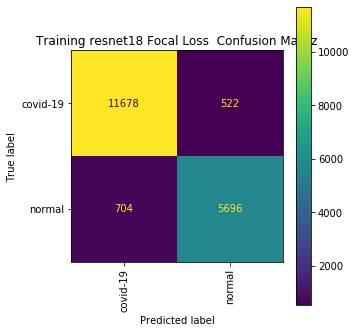

Epochs 9 Training Accuracy :  93.41000000000001  F1 Score :  0.9341
Epochs 9 Validation Confusion Martis
[[[ 570   86]
  [  59 1169]]

 [[1169   59]
  [  86  570]]

 [[1884    0]
  [   0    0]]]


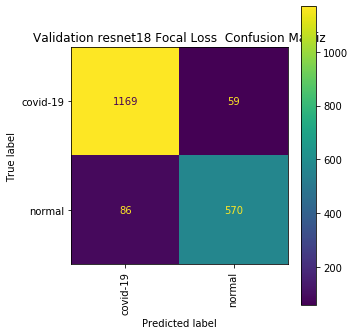

Epochs 9 Validating Accuracy :  92.30000000000001  F1 Score :  0.923


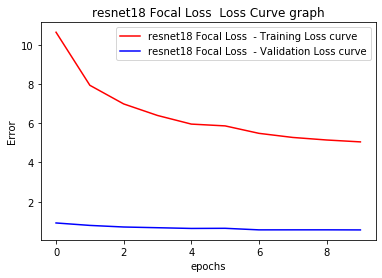

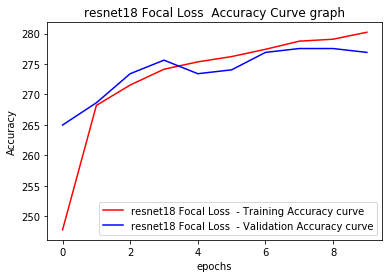

********************** END TRAINING  ******************************


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/A_05_Part_02_Dataset/resnet18_FocalLossT3.pth'

In [8]:
# ####################### Creating Optimizers #################################
optimizer = optim.SGD( modelFT3R.parameters(), learning_rate, 0.9)

####################### Creating Criterion #################################
criterion = FocalLoss()

############################## Training Model ######################################
# model, training_predicting_label, training_true_label, validating_predicting_label, validating_true_label = train(model, trainloader,validloader, optimizer, Epochs, criterion, device, model_name)
modelFT3R = train(modelFT3R, 0.5, trainloader,validloader, optimizer, Epochs, criterion, device, model_name+" Focal Loss ")

# ############################## Saving Model  #######################################


# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [9]:
# ############################## Saving Model  #######################################
pickle.dump(modelFT3R, open('resnet18_FocalLossT3.pth', 'wb'))

# #############################Clear Torch Cache ####################################
torch.cuda.empty_cache()

In [11]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers = 4)

############################### Testing Model ######################################
test(modelFT3R, testloader, device, 0.5, "resnet18_FocalLossT3")


**********************  Testing  ******************************
********************** END Testing  ******************************
